# Task 6 - Project work

### 1. Introduction & Objectives

In this project, we aim to create a classification model that predicts the likelihood of loan approval based on various financial and personal factors of loan applicants. We'll first explore decision trees for transparency, followed by random forests to improve model performance.

### 2. Understanding the Data

#### Loading the data and a quick preview
We will load the data sheet

First let's take a peak at the data and see what it looks like in its raw form:

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv("../Datasets/loan_approval_dataset.csv")


In [11]:
# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Here we can see the total entries is 4269 which represent invidual loan applications. Also there is a total of 13 columns that represents different features of the loan applicants.

Let's check if there is any null values points.

In [12]:
missing_values = df.isnull().sum()
missing_values

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

As we can see, the data is clean so we can move onwards. Let's start plotting the data.

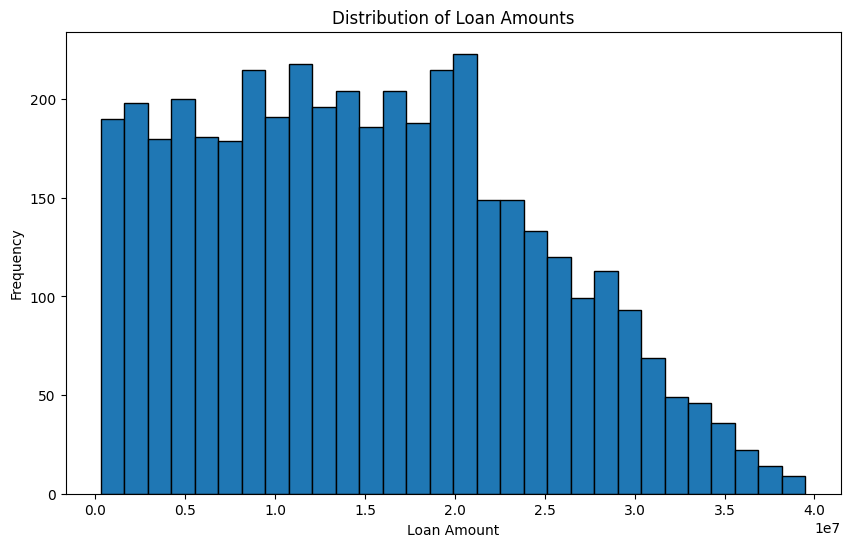

In [26]:
plt.figure(figsize=(10, 6))
df[' loan_amount'].plot(kind='hist', bins=30, edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')
plt.show()

The results shows us that the loan amounts between 0.3 - 2.0 (millions) are the most frequently applied for. However this isn't exactly the key feature we are looking for, but we can still process this even further to see if this is truly the case by comparing loan amount to the loan status.

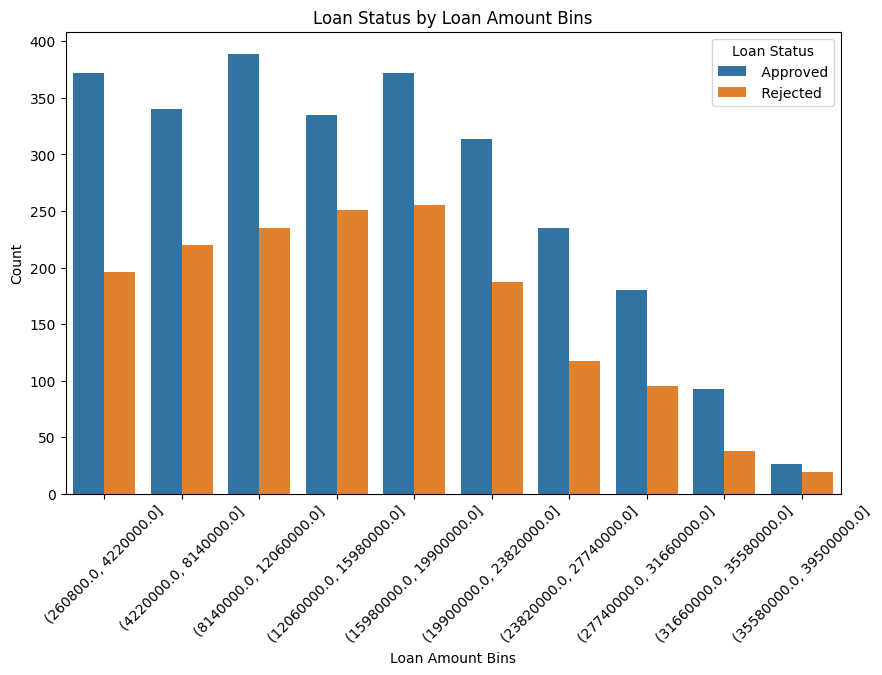

In [39]:

df['loan_amount_bins'] = pd.cut(df[' loan_amount'], bins=10)


plt.figure(figsize=(10, 6))
sns.countplot(x='loan_amount_bins', hue=' loan_status', data=df)
plt.title('Loan Status by Loan Amount Bins')
plt.xlabel('Loan Amount Bins')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)
plt.show()

The loan amount can be ruled out at this point, since we notice the amount doesn't affect the outcome of loan approval. Moving on to analyze the loan count and see how many how the applications got approved and how many rejected.

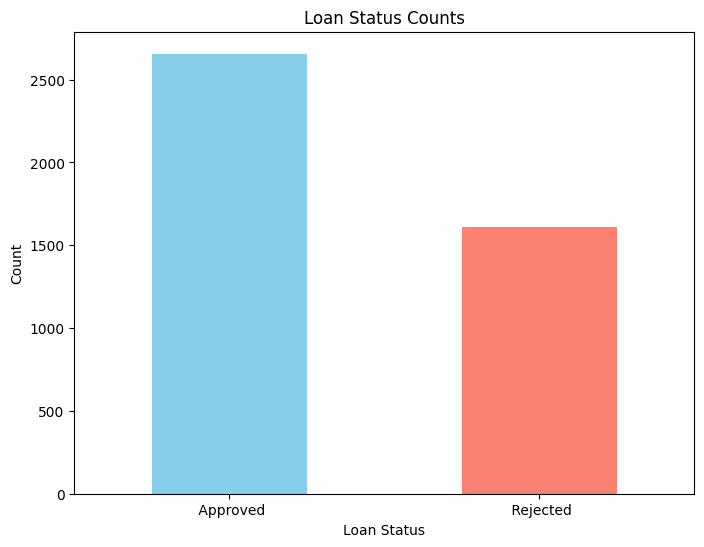

In [40]:

plt.figure(figsize=(8, 6))
df[' loan_status'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Counts')
plt.xticks(rotation=0)
plt.show()


Over 50% got approved of the total loan counts.

<Figure size 1000x600 with 0 Axes>

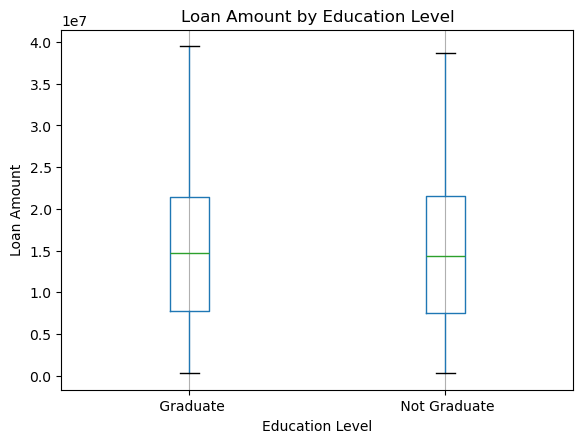

In [55]:
plt.figure(figsize=(10, 6))
df.boxplot(column=' loan_amount', by=' education')
plt.xlabel('Education Level')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Education Level')
plt.suptitle('')  
plt.grid(axis='y')
plt.show()


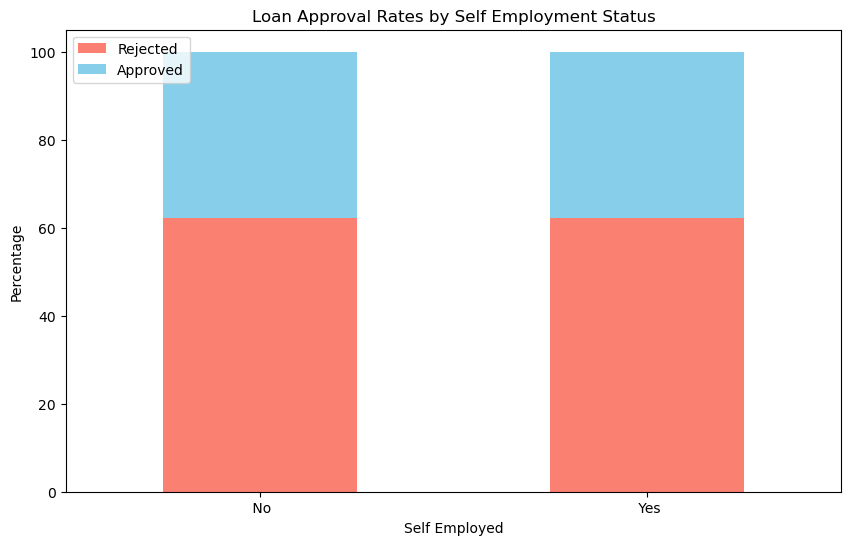

In [56]:
loan_approval_by_self_employed = df.groupby(' self_employed')[' loan_status'].value_counts(normalize=True).unstack() * 100
loan_approval_by_self_employed.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])
plt.xlabel('Self Employed')
plt.ylabel('Percentage')
plt.title('Loan Approval Rates by Self Employment Status')
plt.legend(['Rejected', 'Approved'], loc='upper left')
plt.xticks(rotation=0)
plt.show()


Let's analyze CIBIL Score and it's affection for the Loan Status. We will be using a Strip Plot. Explanation:

Using sns.stripplot: The stripplot function allows for jittering, which helps to spread the points horizontally, preventing overlap and making it clearer how many loans were approved or rejected at each score level.

Dodge and Jitter: The parameters dodge=True and jitter=True help to separate the data points for better visibility. size=6 sets the size of the markers to make them more distinguishable.

Threshold Lines: The vertical lines at CIBIL scores of 550 and 600 remain, visually indicating the significant points in the CIBIL score range.

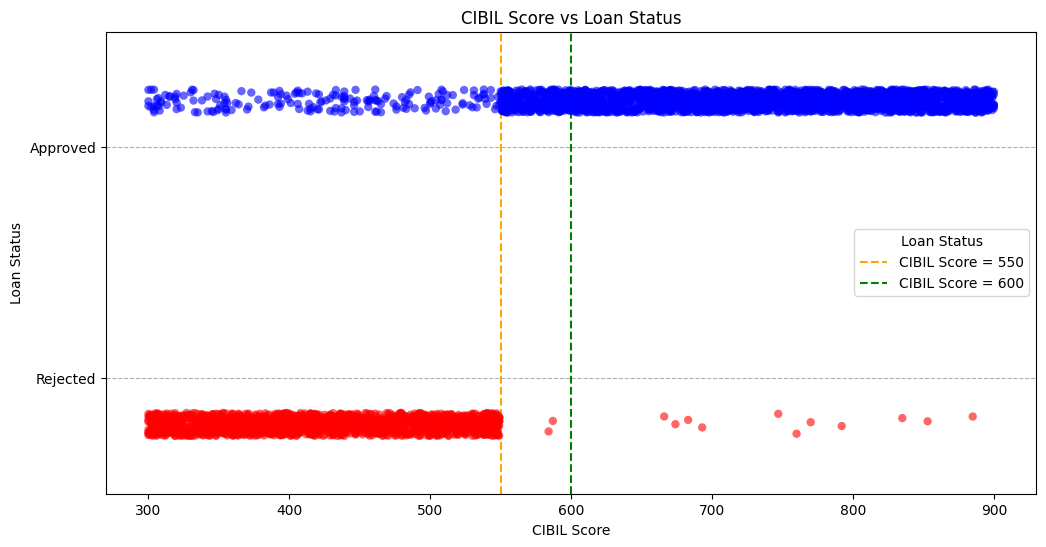

In [65]:
df.columns = df.columns.str.strip()
df['loan_status'] = df['loan_status'].str.strip()


plt.figure(figsize=(12, 6))


sns.stripplot(data=df, x='cibil_score', y='loan_status', hue='loan_status',
               palette={"Approved": "blue", "Rejected": "red"},
               dodge=True, alpha=0.6, jitter=True, marker='o', edgecolor='w', size=6)

plt.axvline(x=550, color='orange', linestyle='--', label='CIBIL Score = 550')
plt.axvline(x=600, color='green', linestyle='--', label='CIBIL Score = 600')


plt.title('CIBIL Score vs Loan Status')
plt.xlabel('CIBIL Score')
plt.ylabel('Loan Status')
plt.legend(title='Loan Status')
plt.grid(axis='y', linestyle='--')
plt.show()


As we can see, clearly the inviduals that seeked for loan with CIBIL Score of under 550 are more common to get Rejected, compared to the ones with CIBIL Score higher than 550. Let's analyze this feature more.

<Figure size 1000x600 with 0 Axes>

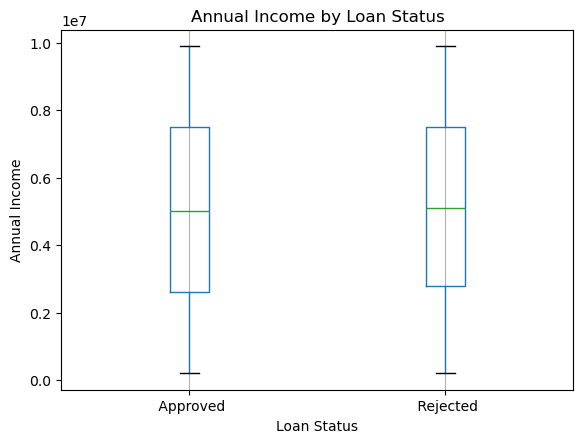

In [58]:
plt.figure(figsize=(10, 6))
df.boxplot(column=' income_annum', by=' loan_status')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.title('Annual Income by Loan Status')
plt.suptitle('')  
plt.grid(axis='y')
plt.show()
